**Exercise 2 Selected**
Use the Facebook stock price (data set gafa_stock) to do the following:

Produce a time plot of the series.
Produce forecasts using the drift method and plot them.
Show that the forecasts are identical to extending the line drawn between the first and last observations.
Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?


Followed the methods from Chapter 5 (The Forecaster’s Toolbox) and applied the models to the Facebook stock data to solve the exercise as below.

In [95]:
!pip install statsforecast datasetsforecast --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, RandomWalkWithDrift, HistoricAverage



In [96]:
# Loading dataset
gafa_stock = pd.read_csv("gafa_stock.csv", parse_dates=["ds"])
gafa_stock.head()

# Checking all Facebook variables
print(gafa_stock[gafa_stock["unique_id"].str.contains("FB")]["unique_id"].unique())

# Selecting only FB_Close (closing price)
fb = gafa_stock.query("unique_id == 'FB_Close'").copy()
fb = fb.sort_values("ds")  # Sorting chronologically
fb.head()

#I sorted the data by date to keep the correct time order before forecasting.
#I used FB_Close since closing prices are most commonly used and reflect daily market sentiment better than other variables.

['FB_Open' 'FB_High' 'FB_Low' 'FB_Close' 'FB_Adj_Close' 'FB_Volume']


,unique_id,ds,y
17612,FB_Close,2014-01-02,54.709999
17613,FB_Close,2014-01-03,54.560001
17614,FB_Close,2014-01-06,57.200001
17615,FB_Close,2014-01-07,57.919998
17616,FB_Close,2014-01-08,58.230000


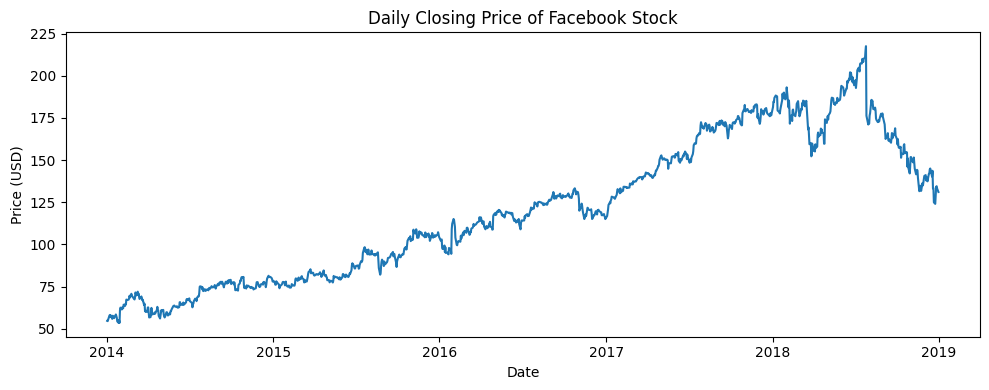

In [97]:
#Time Series Plot
plt.figure(figsize=(10,4))
plt.plot(fb["ds"], fb["y"])
plt.title("Daily Closing Price of Facebook Stock")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

#There is an overall upward trend with noticeable volatility.

In [98]:
# 4. Train / Test Split (last 90 days as test)

train = fb.iloc[:-90].copy()
test  = fb.iloc[-90:].copy()
h = len(test)


# Based on the following the book, I selected the last 90 days as the test set.

In [99]:
drift_model = RandomWalkWithDrift()

sf = StatsForecast(
    models=[drift_model],
    freq="B",      # Business day frequency
    n_jobs=1
)

fc_drift = sf.forecast(df=train, h=h)
fc_drift.head()

# Drift model forecasts show a steady upward trend.


,unique_id,ds,RWD
0,FB_Close,2018-08-22,172.721032
1,FB_Close,2018-08-23,172.822069
2,FB_Close,2018-08-24,172.923106
3,FB_Close,2018-08-27,173.024142
4,FB_Close,2018-08-28,173.125179


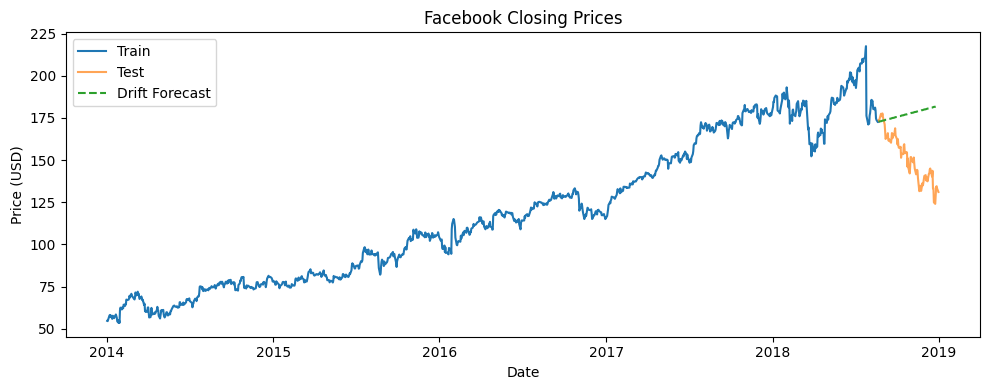

In [100]:
plt.figure(figsize=(10,4))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test", alpha=0.7)
plt.plot(fc_drift["ds"], fc_drift["RWD"], label="Drift Forecast", linestyle="--")

plt.title("Facebook Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

#The drift model follows the trend but does not show the recent drop.

In [101]:
# Verifying the drift model formula
y = train["y"].values
T = len(y)
y1, yT = y[0], y[-1]
b = (yT - y1) / (T - 1)

# Drift calculation
horizons = np.arange(1, h+1)
drift_manual = yT + b * horizons

# Compare with StatsForecast results
drift_model_fc = fc_drift["RWD"].values
np.allclose(drift_manual, drift_model_fc)


True

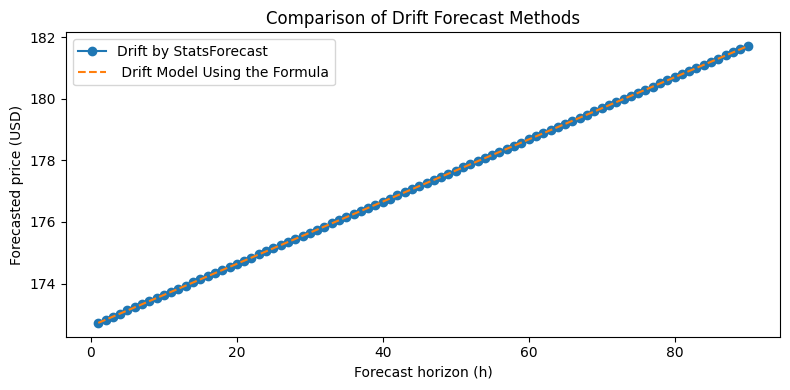

In [102]:
# Visual comparison between drift method with formula and StatsForecast
plt.figure(figsize=(8,4))
plt.plot(horizons, drift_model_fc, marker="o", label="Drift by StatsForecast")
plt.plot(horizons, drift_manual, linestyle="--", label=" Drift Model Using the Formula")
plt.xlabel("Forecast horizon (h)")
plt.ylabel("Forecasted price (USD)")
plt.title("Comparison of Drift Forecast Methods")
plt.legend()
plt.tight_layout()
plt.show()

# This verifies that the forecasts match the line between the first and last observations.


In [103]:
models = [
    RandomWalkWithDrift(),
    Naive(),
    SeasonalNaive(season_length=5),   # Weekly Seasonality(5 business days)
    HistoricAverage()
]

model_names = ["RWD", "Naive", "SeasonalNaive", "HistoricAverage"]

sf = StatsForecast(
    models=models,
    freq="B",
    n_jobs=1
)

# Forecast all models
preds = sf.forecast(df=train, h=h)

preds["y"] = test["y"].values

preds.head()

#Different methods(Mean, Drift, Naive, Seasonal Naive)used to compare forecasting performance.


,unique_id,ds,RWD,Naive,SeasonalNaive,HistoricAverage,y
0,FB_Close,2018-08-22,172.721032,172.619995,179.529999,118.054538,173.639999
1,FB_Close,2018-08-23,172.822069,172.619995,174.699997,118.054538,172.899994
2,FB_Close,2018-08-24,172.923106,172.619995,173.800003,118.054538,174.649994
3,FB_Close,2018-08-27,173.024142,172.619995,172.500000,118.054538,177.460007
4,FB_Close,2018-08-28,173.125179,172.619995,172.619995,118.054538,176.259995


In [104]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape, mase

metrics = [
    rmse,
    mae,
    mape,
    partial(mase, seasonality=5)
]

# Evaluating all models
eval_df = evaluate(
    df=preds,
    metrics=metrics,
    models=model_names,
    train_df=train
)

eval_df

# Among all models, the Naive method has the lowest RMSE, MAE, MAPE and MASE values.
# Therefore, it performs best and gives the most accurate forecasts.


,unique_id,metric,RWD,Naive,SeasonalNaive,HistoricAverage
0,FB_Close,rmse,30.080751,24.862578,26.643074,36.246769
1,FB_Close,mae,25.940343,21.423996,23.236221,33.657462
2,FB_Close,mape,0.181309,0.149773,0.161937,0.215673
3,FB_Close,mase,8.107948,6.696312,7.262744,10.520021


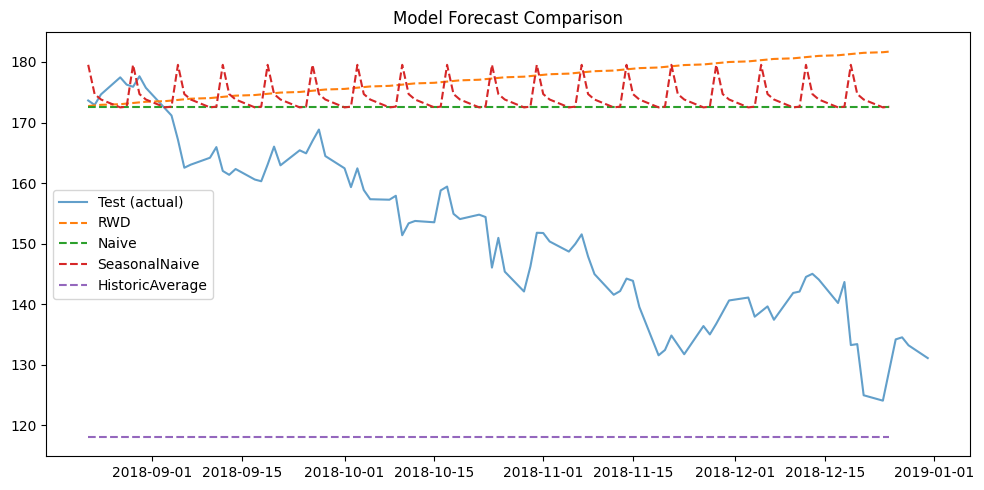

In [105]:
plt.figure(figsize=(10,5))
plt.plot(test["ds"], test["y"], label="Test (actual)", alpha=0.7)
for model in model_names:
    plt.plot(preds["ds"], preds[model], linestyle="--", label=model)
plt.title("Model Forecast Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# The Naive model stays flat, Drift model slowly increases over time. The SeasonalNaive model captures weekly seasonality, and the HistoricAverage(Mean) remains at the mean level.